In [1]:
import numpy as np
import pandas as pd
from nltk import *
import json
from keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from keras.layers import *
from keras.initializers import Constant
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Model
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import keras.backend as K

Using TensorFlow backend.


In [2]:
#import dataset
file = 'News_Category_Dataset.json'
data = pd.read_json(file, lines = True)

cats = data.groupby('category')

# We see that the categories 'THE WORLDPOST' and 'WORLDPOST' are the same. We need to combine them.
data.category = data.category.map(lambda x: 'WORLDPOST' if x =='THE WORLDPOST' else x)

# Construct a 'text' column in the dataframe that contains the headline and short descriptions
data['text'] = data.headline + ' ' + data.short_description

In [3]:
# We tokenize the text, write them into a new 'words' column.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)

T = tokenizer.texts_to_sequences(data.text)
data['words'] = T

# We neglect the entries with a short text.
data['word_length'] = data.words.apply(lambda x: len(x))
data = data[data.word_length>=5]

# We index the categories
catergories = data.groupby('category').size().index.tolist()

cat_to_int = {}
int_to_cat = {}
for i, k in enumerate(catergories):
    cat_to_int.update({k:i})
    int_to_cat.update({i:k})
    
data['cat_id'] = data['category'].apply(lambda x: cat_to_int[x])

/Users/Xuntao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# We now upload the GloVe model (50D version). Getting ready for word embedding.

EMBEDDING_DIM = 50
embedding_index = {}
f = open('/Users/Xuntao/DataScience/glove.6B.50d.txt')

for line in f:
    vector = line.split()
    word = vector[0]
    coefs = np.asarray(vector[1:], dtype = 'float32')
    embedding_index[word] = coefs
    
f.close()

# Construct the embedding matrix

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [5]:
# Construct a layer that embeds all the text using the embedding matrix above.
maxlen = 50
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [6]:
# Prepare Data

X = list(sequence.pad_sequences(data.words, maxlen = maxlen))
X = np.array(X)
Y = np_utils.to_categorical(list(data.cat_id))

# Split the training and validating sets

X_train, X_val, Y_train, Y_val = tts(X,Y, test_size = 0.2, random_state = 29)

In [7]:
#Setting up a plotting function to plot (and compare) the training histories
def train_val_ploting(my_history):
    plt.rcParams['figure.figsize'] = (6,6)

    plt.rcParams['figure.figsize'] = (6,6)

    acc = my_history.history['acc']
    val_acc = my_history.history['val_acc']
    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()

    plt.show()

In [8]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [9]:
# Define one step attention

repeator = RepeatVector(maxlen)
concatenator = Concatenate(axis = -1)
densor1 = Dense(10, activation = 'tanh')
densor2 = Dense(1, activation = 'relu')
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

def one_time_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    E = densor1(concat)
    E = densor2(E)
    alphas = activator(E)
    context = dotor([alphas, a])
    
    return context

In [14]:
n_a = maxlen
n_s = 2*n_a
post_attention_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(catergories), activation=softmax)

# Bidirectional LSTM with Attention
def model(maxlen, n_a, n_s):
    inp3 = Input(shape = (maxlen,), dtype = 'int32')
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    emb = embedding_layer(inp3)
    
    a = Bidirectional(LSTM(n_a, return_sequences = True))(emb)
    
    for t in range(10):
        context = one_time_attention(a, s)
        s, _, c = post_attention_LSTM_cell(context, initial_state = [s,c])
    
    out = output_layer(s)
    
    model = Model(inputs = [inp3, s0, c0], outputs = out)
    return model

In [15]:
LSTM_model = model(maxlen, n_a, n_s)
LSTM_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       4331400     input_2[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 100)          0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 100)      40400       embedding_1[1][0]                
__________________________________________________________________________________________________
repeat_vec

In [16]:
LSTM_model.compile(loss = 'categorical_crossentropy', 
                    optimizer = 'adam', 
                    metrics = ['accuracy'])

In [21]:
m0 = len(X_train)
s0 = np.zeros((m0, n_s))
c0 = np.zeros((m0, n_s))

m1 = len(X_val)
s1 = np.zeros((m1, n_s))
c1 = np.zeros((m1, n_s))

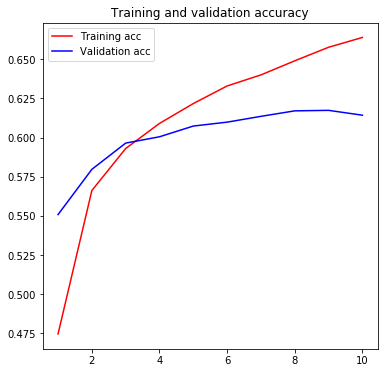

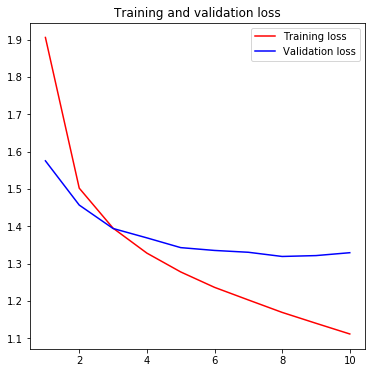

In [24]:
train_val_ploting(LSTM_history)